# ADA2017 project, milestone 2
# Data processing pipeline

In [104]:
# To use Spark 1.6.3 in Jupyter Notebook we have to use Python 3.4
!python --version

Python 3.4.5 :: Anaconda 4.3.1 (64-bit)


In [1]:
# USER to determine spark and dataset directories
import getpass
USER = getpass.getuser()
if USER == 'Tarmo':
    SPARK_DIR = 'C:/Users/Tarmo/Documents/Lausanne/CS-401_applied_data_analysis/spark/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/Books_5.json'
    METADATA_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/meta_Books.json'
elif USER == 'adam':
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/reviews_Books_5.json'
    METADATA_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/meta_Books.json'
else:
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'

In [ ]:
SPARK_DIR

### Import libraries
#### Spark libraries

In [106]:
import findspark
findspark.init(SPARK_DIR)

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import to_date, unix_timestamp, from_unixtime  #to_timestamp, pyspark 2.2 functiona 

#### The others

In [3]:
import pandas as pd
from scipy import stats
import numpy as np
import json
import re
import json 
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Collection and aggregation of data
Loading and processing the data to see what it contains. To make further processing faster, we create intermediate well-structured csv files to avoid having to process the JSON data files every time we want to look at the data. We take a look at several different metrics and their aggregates in the data (review length, review number; by day, by month, by year, by book, etc.)

### Initialization of Spark and SQL context

In [107]:
sc = SparkContext()
sqlContext = SQLContext(sc)

sc.version

'1.6.3'

### Loading of dataset and metadata

In [108]:
# Load the dataset and create RDDs
text_file = sc.textFile(DATASET_DIR)
# Convert previously read text file to json DataFrame
df = sqlContext.read.json(text_file)

# Load metadata for dataset and convert it to DataFrame
metadata = sc.textFile(METADATA_DIR)
metadata_df = sqlContext.read.json(metadata)

# Register DataFrames as tables to use those names in SQL-type queries
sqlContext.registerDataFrameAsTable(metadata_df, "metadata")
sqlContext.registerDataFrameAsTable(df, "dataset")

In [109]:
# Number of RDDs
text_file.getNumPartitions()

282

In [110]:
# Number of records in the dataset
text_file.count()

8898041

In [111]:
# Schema of the dataset
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



### Initial data processing

In [112]:
# Bunch of castings, reviewTime: string->date, unixReviewTime: int->timestamp
# We do this to be able to better filter and manipulate the data
df = df.withColumn('unixReviewTime', from_unixtime(df['unixReviewTime']))
df = df.withColumn('reviewTime', to_date(df['unixReviewTime']))
df = df.withColumn('unixReviewTime', df['unixReviewTime'].cast('timestamp'))
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: date (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: timestamp (nullable = true)



In [113]:
# Look at couple of records, just to be sure that we obtained what we wanted
df.select("reviewTime", 'reviewText', 'unixReviewTime').take(2)

[Row(reviewTime=datetime.date(2012, 12, 16), reviewText='Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!', unixReviewTime=datetime.datetime(2012, 12, 16, 1, 0)),
 Row(reviewTime=datetime.date(2003, 12, 11), reviewText="This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is rather simplistically written, but the message behind it is so powerful that you have to read it. It will take you to enlightenment.", unixReviewTime=datetime.datetime(2003, 12, 11, 1, 0))]

### Average length of reviews per day

In [ ]:
# Computing an average length of review per day
aTuple = (0, 0)
avg = df.select("reviewTime", 'reviewText').rdd.map(lambda row: (row.reviewTime, len(row.reviewText)))
avg = avg.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg = avg.mapValues(lambda v: v[0]/v[1])
avg = avg.collect()

In [ ]:
# Processing acquired data using Pandas
avg_len = pd.DataFrame(avg, columns=['Date', 'Avg_length'])
avg_len['Date'] = pd.to_datetime(avg_len['Date'])
avg_len.set_index('Date', inplace=True)
avg_len.sort_index(inplace=True)
avg_len.head()

In [ ]:
# Save to file not to compute this one more time
avg_len.to_csv("avg_length_review_by_day.csv")

In [6]:
avg_len = pd.read_csv("avg_length_review_by_day.csv", index_col='Date', parse_dates=['Date'])
avg_len.head()

,Avg_length
Date,
1996-05-20,1752.0
1996-06-25,1123.0
1996-08-17,826.0
1996-09-18,897.0
1996-11-15,1757.0


### Average length of reviews per month

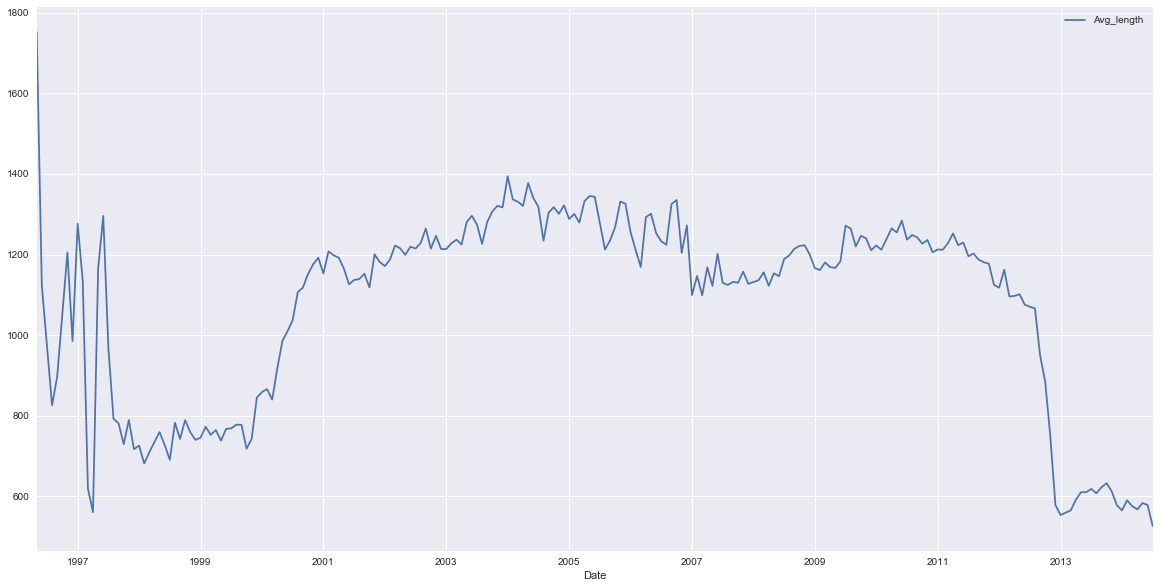

In [115]:
monthly_data = avg_len.groupby(avg_len.index.to_period('M')).mean()
monthly_data.plot(figsize=(20,10))

We notice that the average review length per month appears to have three somewhat stable levels in time: before 2000, between 2000 and 2013 and after 2013. In the middle period the review length is consistently high, and crashes around 2012-2013. In the beginning of the dataset time period, the number of reviews is small so there is high variation in monthly average.

### Average length of reviews between 2012 and 2013

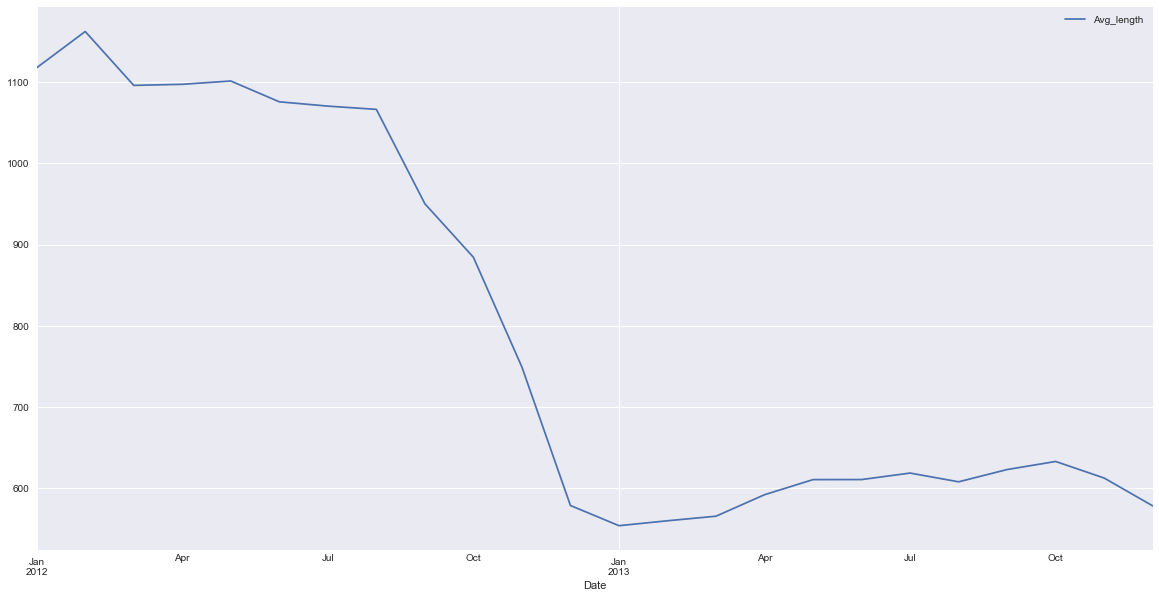

In [116]:
monthly_data['2012':'2013'].plot(figsize=(20,10))

The extreme drop is located between August 2012 and January 2013.

In [ ]:
# Save processed data
monthly_data.to_csv("avg_length_review_by_month.csv")

In [ ]:
# (Successful) attempt to filter by timestamp 
tmp = df.rdd.filter(lambda row: row.unixReviewTime > pd.to_datetime('2012-05')
                     and row.unixReviewTime < pd.to_datetime('2013'))
tmp.take(5)

### Number of reviews per each day

In [ ]:
# Number of reviews per each day
number_of_reviews = df.rdd.map(lambda row: (row.reviewTime, 1)).reduceByKey(lambda a, b: a+b).collect()

In [ ]:
# Processing the data
rev_num = pd.DataFrame(number_of_reviews, columns=['Date', 'Number of reviews'])
rev_num['Date'] = pd.to_datetime(rev_num['Date'])
rev_num.set_index('Date', inplace=True)
rev_num.sort_index(inplace=True)
rev_num.head()

In [ ]:
# Save the data not to compute over and over
rev_num.to_csv("number_of_reviews_per_day.csv")

In [9]:
# Read file with the data
rev_num = pd.read_csv("number_of_reviews_per_day.csv", index_col='Date', parse_dates=['Date'])
rev_num.tail()

,Number of reviews
Date,
2014-07-19,2797
2014-07-20,3332
2014-07-21,3456
2014-07-22,2697
2014-07-23,619


### Number of reviews per month

In [ ]:
monthly_data_reviews = rev_num.groupby(rev_num.index.to_period('M')).sum()
# Save the processed data
monthly_data_reviews.to_csv("number_of_reviews_per_month.csv")

In [118]:
# Read file with the data
monthly_data_reviews = pd.read_csv("number_of_reviews_per_month.csv", index_col='Date', parse_dates=['Date'])

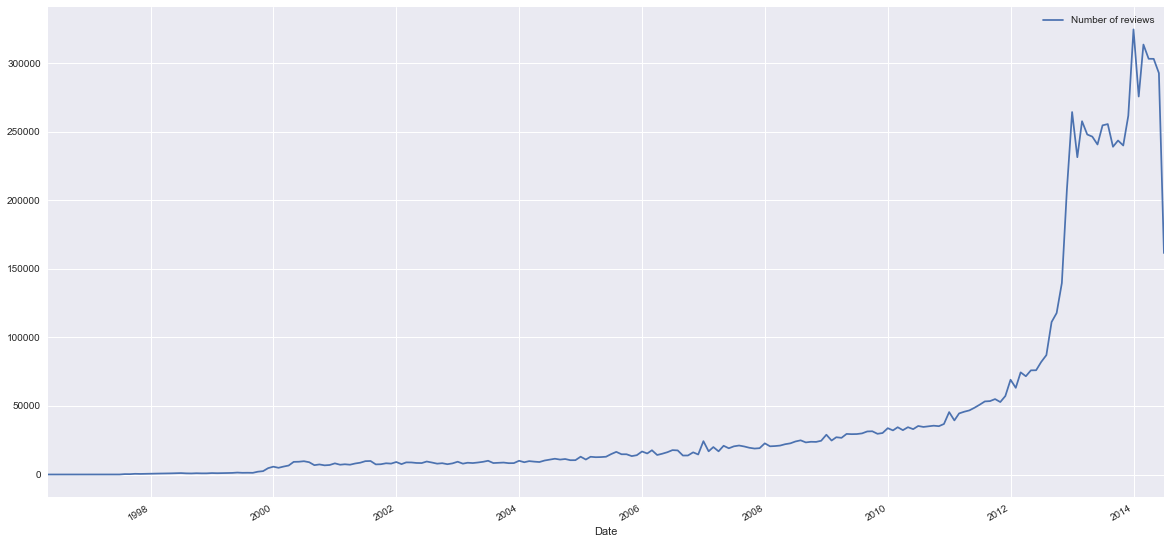

In [119]:
monthly_data_reviews.plot(figsize=(20,10))

We see that in the beginning of the data period, there are hardly any reviews being written. The number of reviews increases consistently until there is a huge jump after 2012. The extreme increase coincides with the drop in the average review length, and may reflect a sudden change in reviewer numbers and/or behavior. The apparent increase might also be due to changes in Amazon review policies: after a significant change, Amazon might retroactively remove old reviews not conforming to the new policy.

### Number of reviews per book

In [ ]:
number_of_reviews_per_book = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).collect()
len(number_of_reviews_per_book)

In [ ]:
# Processing the data using Pandas and saving it to csv file
df_number_of_reviews_per_book = pd.DataFrame(number_of_reviews_per_book, columns=['Book_id', 'Number of reviews'])
df_number_of_reviews_per_book.sort_values('Number of reviews', ascending=False, inplace = True)
df_number_of_reviews_per_book.to_csv("number_of_reviews_per_book.csv", index=False)
df_number_of_reviews_per_book.head(10)

In [120]:
# Read file with the data
df_number_of_reviews_per_book = pd.read_csv("number_of_reviews_per_book.csv", index_col='Book_id')

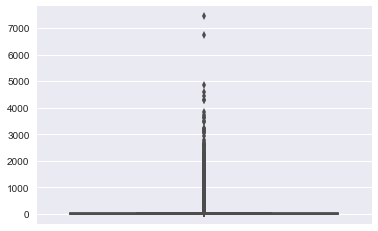

In [129]:
# Boxplot of numbers of reviews
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v')

The boxplot is not very box-like, since most books have only a small number of reviews.

We look at the numbers without the outliers:

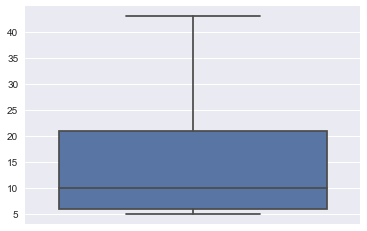

In [130]:
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v', showfliers=False)

In [131]:
# Basic statistics for this variable
stats.describe(df_number_of_reviews_per_book['Number of reviews'].values)

DescribeResult(nobs=367982, minmax=(5, 7440), mean=24.180641987923323, variance=4396.0938613274502, skewness=25.747403776095645, kurtosis=1461.9790549248125)

## Top 30 books based on the number of reviews
Our time-independent popularity metric is the number of reviews, so we take a closer look at the top 30 books according to it.

In [ ]:
top_books = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).sortBy(lambda wc: -wc[1]).take(30)

top_books_df = sqlContext.createDataFrame(top_books, ['asin', 'rew_num'])
sqlContext.registerDataFrameAsTable(top_books_df, "top_books")
top_books_df.take(5)

In [ ]:
# Join the dataset table with the metadata table to see titles of the most popular books
sqlContext.sql("select t.asin, m.title from metadata m join top_books t on m.asin=t.asin").collect()

In [ ]:
sqlContext.sql("select t.asin, m.title from metadata m join top_books t limit 10").collect()

### Two methods of filtering by ids of books

In [ ]:
most_reviewed_books_id_top = df_number_of_reviews_per_book[:30]
most_reviewed_top = df.rdd.filter(lambda row: row.asin in list(most_reviewed_books_id_top.Book_id))
            .map(lambda row: (row.asin, row.reviewTime)).collect()

In [ ]:
most_reviewed_top_2 = sqlContext.sql("select asin, reviewTime from dataset where asin in " + 
               str(tuple(most_reviewed_books_id_top.Book_id)))

### Processing the data for top30 books

In [ ]:
# Processing the data using Pandas
most_reviewed_books_top30_df = pd.DataFrame(most_reviewed_top, columns=['asin', 'reviewTime'])
# Convert to datetime type
most_reviewed_books_top30_df['reviewTime'] = pd.to_datetime(most_reviewed_books_top30_df['reviewTime'])
# Assign number of review to compute the sum
most_reviewed_books_top30_df['Number_of_reviews'] = 1
# Create monthly period for aggregation purpose
most_reviewed_books_top30_df['Year-month'] = most_reviewed_books_top30_df['reviewTime'].dt.to_period('M')
most_reviewed_books_top30_df.head()

In [ ]:
# Save data describing number of reviews per day for each book in top30
most_reviewed_books_top30_df.groupby(['asin', 'reviewTime']).sum()
                            .to_csv("number_of_reviews_per_day_top30_books.csv")

In [ ]:
# Aggregating the data by month
m_rev_books_by_month = most_reviewed_books_top30_df.groupby(['asin', 'Year-month'], as_index=True).sum()
m_rev_books_by_month.to_csv("number_of_reviews_per_month_top30_books.csv")

In [133]:
m_rev_books_by_month = pd.read_csv("number_of_reviews_per_month_top30_books.csv").set_index(['asin', 'Year-month'])

### Multi-line plot for top30 books - timeseries of reviews per month

In [ ]:
m_rev_books_by_month.unstack(level=0).to_csv("number_of_reviews_per_month_top30_books_UNSTACKED.csv")

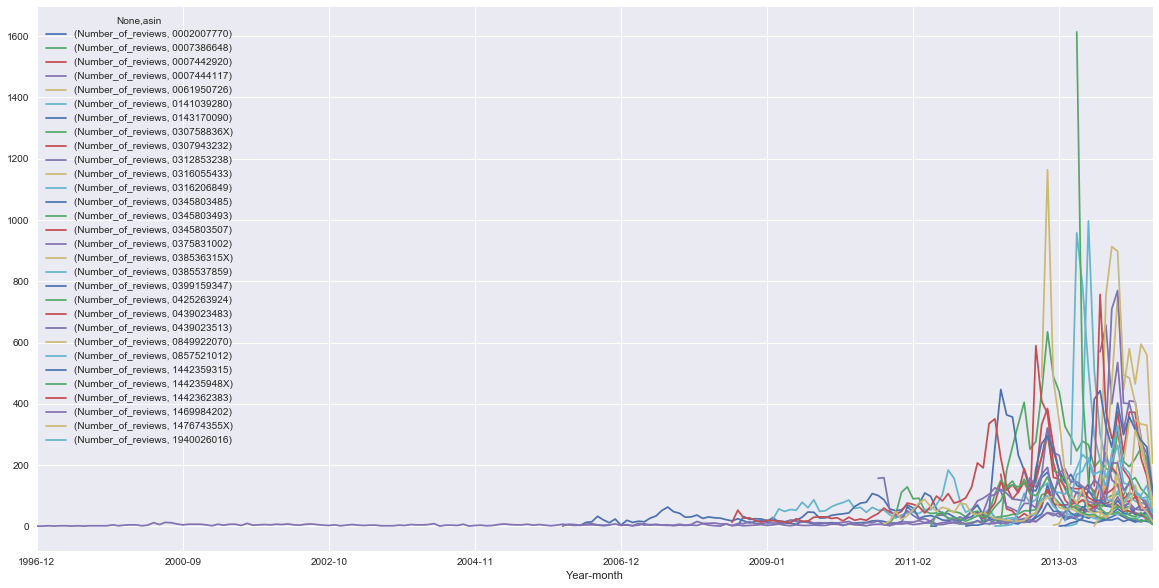

In [134]:
m_rev_books_by_month.unstack(level=0).plot(figsize = (20,10))

We see that for the top 30 books, most reviews are made after January 2013.

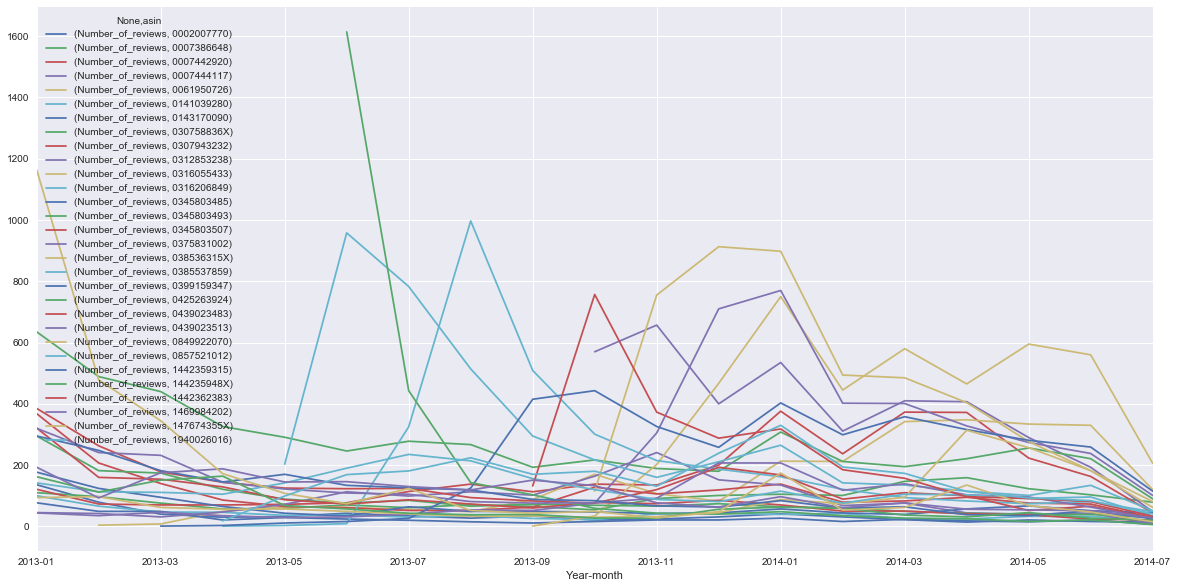

In [135]:
m_rev_books_by_month.unstack(level=0)['2013':].plot(figsize = (20,10))

A top 30 book accrues a lot of reviews right after publication (or rather, appearance of first review). It is highly book-dependent whether this rate of reviewing drops quickly or slowly.

### Average length and number of reviews per book

In [ ]:
aTuple = (0, 0)
avg_len_review = df.select('asin', 'reviewText').rdd.map(lambda row: (row.asin, len(row.reviewText)))
avg_len_review = avg_len_review.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg_len_review = avg_len_review.mapValues(lambda v: (v[0]/v[1], v[1]))
avg_len_review = avg_len_review.collect()

In [ ]:
# Transformation of the data to be able to load it as a DataFrame 
avg_len_review = [(k, v1, v2) for k, (v1, v2) in avg_len_review]

In [ ]:
# Processing and saving to file
avg_len_review_per_book_df = pd.DataFrame(avg_len_review, columns=['Book_id', 'Avg_len', 'number_of_reviews'])
avg_len_review_per_book_df.sort_values(['Avg_len', 'number_of_reviews'], ascending=False, inplace=True)
avg_len_review_per_book_df.to_csv("avg_length_and_number_of_reviews_per_book.csv", index=False)
avg_len_review_per_book_df.head(10)

In [13]:
avg_len_review_per_book_df = pd.read_csv("avg_length_and_number_of_reviews_per_book.csv",index_col="Book_id")
avg_len_review_per_book_df.head()

,Avg_len,number_of_reviews
Book_id,,
0195396170,13459.5,6
0700619542,9934.8,5
0061312118,9511.1,10
0875522645,9377.8,5
1405159286,8716.0,9


## Ratings
### Collecting the data about ratings
Each row contains: book serial number, date of the review, rating (overall). We construct an intermediate file where each book (asin) is associated with five column features, which give the number of ratings from 1 to 5, respectively.

Rating is in stars (integers), from 1 to 5.

In [ ]:
ratings = df.select("asin", "reviewTime", "overall").rdd.map(lambda row: (row.asin, row.reviewTime, int(row.overall))).collect()

In [ ]:
ratings_df = pd.DataFrame(ratings, columns=['asin', 'Date', 'rating'])
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
ratings_df.shape

In [ ]:
# Save the data
ratings_df.to_csv("ratings.csv", index=False)

In [ ]:
# Aggregate data by number of each 1, 2, 3, 4, 5 ratings
ratings_grouped_df = ratings_df.groupby(['asin', 'rating']).count()
ratings_grouped_unstack_df = ratings_grouped_df.unstack(level=1, fill_value=0)
ratings_grouped_unstack_df.columns = ratings_grouped_unstack_df.columns.droplevel()
ratings_grouped_unstack_df.to_csv("ratings_grouped_unstack.csv")
ratings_grouped_unstack_df.head()

In [5]:
ratings_grouped_unstack_df = pd.read_csv('ratings_grouped_unstack.csv', index_col='asin')
ratings_grouped_unstack_df.head()

,1,2,3,4,5
asin,,,,,
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5


Column 1 contains the number of 1-star ratings, etc.

In [11]:
ratings_grouped_unstack_df.rename(columns={1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}, inplace=True)

# Data analysis

http://rogeriofvieira.com/wp-content/uploads/2016/05/Data-Transformations-1.pdf

In [22]:
ratings_grouped_unstack_df['Weighted_mean'] = (np.array(ratings_grouped_unstack_df.values).dot([1, 2, 3, 4, 5]))/np.sum(np.array(ratings_grouped_unstack_df.values), axis=1)

In [54]:
ratings_grouped_unstack_df['Trans_weighted_mean'] = np.log10(6 - ratings_grouped_unstack_df['Weighted_mean'].values)

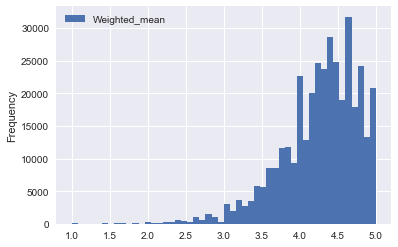

In [103]:
ratings_grouped_unstack_df.plot(y = 'Weighted_mean', kind = 'hist', bins = 50, logx=False)

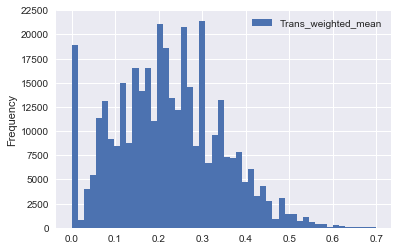

In [98]:
ratings_grouped_unstack_df.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

In [66]:
ratings_grouped_unstack_df['Inverse_weighted_mean'] = 1/(6 - ratings_grouped_unstack_df['Weighted_mean'].values)

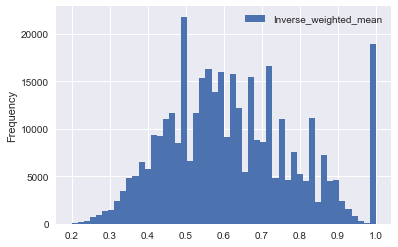

In [99]:
ratings_grouped_unstack_df.plot(y = 'Inverse_weighted_mean', kind = 'hist', bins = 50, logx=False)

In [80]:
ratings_grouped_unstack_df['Number_of_reviews'] = ratings_grouped_unstack_df.iloc[:, :5].sum(axis = 1)
ratings_grouped_unstack_df.head()

In [82]:
ratings_grouped_unstack_df_10 = ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 10]
ratings_grouped_unstack_df_10.head()

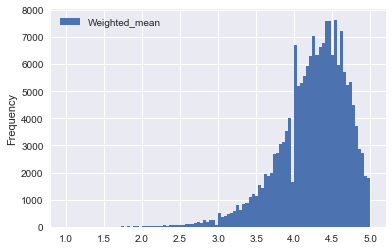

In [93]:
ratings_grouped_unstack_df_10.plot(y = 'Weighted_mean', kind = 'hist', bins = 100, logx=False)

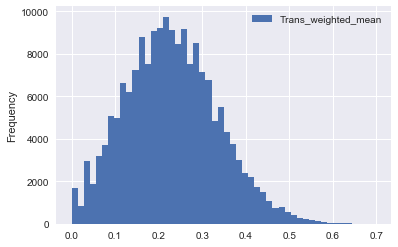

In [102]:
ratings_grouped_unstack_df_10.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

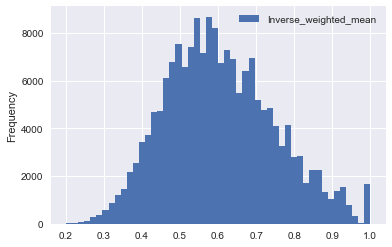

In [95]:
ratings_grouped_unstack_df_10.plot(y = 'Inverse_weighted_mean', kind = 'hist', bins = 50, logx=False)

In [ ]:
# Spark context shutdown
sc.stop()